### Very Simple Example (single reaction)

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import solve_ivp, odeint

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [2]:
# Define the system of ODEs
def model(y, t, k1, k2):
    dy1dt = -k1 * y[0]
    dy2dt = k1 * y[0] - k2 * y[1]
    return [dy1dt, dy2dt]

y0 = [1, 0]  # Initial conditions
T_START = 0
T_END = 2
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k1 = 5
k2 = 1
solution = odeint(model, y0, t, args=(k1,k2))

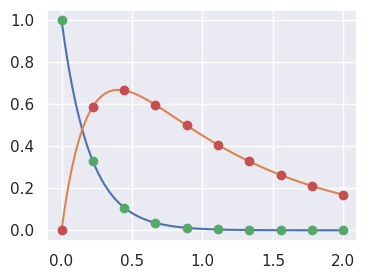

In [3]:
# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)
z_2 = lambda t: 5/4 * np.exp(-5 * t) * (-1 + np.exp(4 * t))

# Create true data
t_true = torch.from_numpy(t).float().view(-1,1).to(DEVICE)
y_true = torch.from_numpy(solution).float().to(DEVICE)

# Make training data
n_samples = 10
t_train = torch.linspace(T_START, 2, n_samples).view(-1,1).requires_grad_(True).to(DEVICE)
y_train_1 = z_1(t_train.cpu().detach().numpy())
y_train_2 = z_2(t_train.cpu().detach().numpy())
# Stack the two solutions using numpy 
y_train = np.hstack((y_train_1, y_train_2))

# Plot true and training data 
plt.figure(figsize=(4,3))
plt.plot(t_true.cpu().numpy(), y_true .cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_train[:,0], 'o')
plt.plot(t_train.cpu().detach().numpy(), y_train[:,1], 'o')
plt.show()

In [20]:
# Make a NN for u
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 10)
        self.fc3 = nn.Linear(10, 2)
        
        self.k2 = nn.Parameter(torch.tensor([1.0]))
        self.k1 = nn.Parameter(torch.tensor([1.0]))
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)
us_train = torch.tensor(y_train, requires_grad=True).float().to(DEVICE)

/tmp/ipykernel_1536510/3687197062.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)


In [55]:
def residuals(t, model: nn.Module):
    t = torch.linspace(T_START, T_END, 500).view(-1,1).to(DEVICE)
    t.requires_grad = True  
    u = model(t).to(DEVICE)
    u_t_1  = torch.autograd.grad(u[:,0], t, grad_outputs=torch.ones_like(u[:,0]), create_graph=True)[0]
    u_t_2  = torch.autograd.grad(u[:,1], t, grad_outputs=torch.ones_like(u[:,1]), create_graph=True)[0]
    error_1 = u_t_1 - (-model.k1 * u[:,0])
    error_2 = u_t_2 - (model.k1 * u[:,0] - model.k2 * u[:,1])
    e_1 = torch.mean(error_1)
    e_2 = torch.mean(error_2)
    return e_1**2+e_2**2

In [56]:
network = Network().to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 20000
LOSS = []
for epoch in range(EPOCHS):
    
    u_pred = network.forward(ts_train)
    residual_pred = residuals(ts_train, network)
    
    loss = criterion(u_pred, us_train)
    loss += torch.mean(residual_pred**2)
    
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}] Loss: {loss}, k1: {network.k1.item()}, k2: {network.k2.item()}')
        

Epoch [0/20000] Loss: 0.5741445422172546, k1: 1.0010000467300415, k2: 0.9990000128746033


Epoch [500/20000] Loss: 0.03022802248597145, k1: 1.3768224716186523, k2: 0.873659610748291
Epoch [1000/20000] Loss: 0.018358364701271057, k1: 1.7658909559249878, k2: 0.7976120114326477
Epoch [1500/20000] Loss: 0.0036615801509469748, k1: 2.100208282470703, k2: 0.7533513903617859
Epoch [2000/20000] Loss: 0.001196945202536881, k1: 2.424553155899048, k2: 0.7017205953598022
Epoch [2500/20000] Loss: 0.0006627768743783236, k1: 2.697190523147583, k2: 0.6681424975395203
Epoch [3000/20000] Loss: 0.0004188283928669989, k1: 2.9236865043640137, k2: 0.6654059886932373
Epoch [3500/20000] Loss: 0.0002761092910077423, k1: 3.123147487640381, k2: 0.6840437650680542
Epoch [4000/20000] Loss: 0.0001841190387494862, k1: 3.305441379547119, k2: 0.7127739191055298
Epoch [4500/20000] Loss: 0.0001219053883687593, k1: 3.4739551544189453, k2: 0.7444193363189697
Epoch [5000/20000] Loss: 7.97373941168189e-05, k1: 3.629204511642456, k2: 0.7752061486244202
Epoch [5500/20000] Loss: 5.1750426791841164e-05, k1: 3.77081179

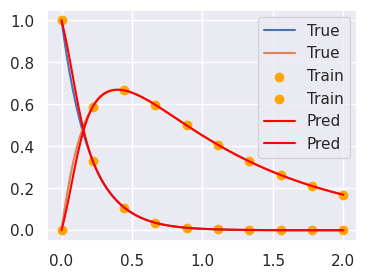

In [57]:
# Plot u_pred vs ts
network.eval()
with torch.no_grad():
    u_pred = network(t_true)
    plt.figure(figsize=(4,3))
    plt.plot(t_true.cpu(), y_true.cpu(), label='True')
    plt.scatter(t_train.cpu(), y_train[:,0], label='Train', color='orange')
    plt.scatter(t_train.cpu(), y_train[:,1], label='Train', color='orange')
    plt.plot(t_true.cpu(), u_pred[:,0].cpu().numpy(), label='Pred', color='red')
    plt.plot(t_true.cpu(), u_pred[:,1].cpu().numpy(), label='Pred', color='red')
    plt.legend()
    plt.show()

In [40]:
network.k1, network.k2

(Parameter containing:
 tensor([1.], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([1.0719], device='cuda:0', requires_grad=True))

In [ ]:
# Stack column torch
def stack_col(tensors):
    return torch.stack(tensors, 1).squeeze()

In [3]:
def grad(outputs, inputs):
    """ Computes the partial derivative of 
    an output wrt an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True, allow_unused=True)

In [4]:
def np_to_ts(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units=100) -> None:
        
        super().__init__()
        self.n_units = n_units
        
        self.k = nn.Parameter(torch.tensor([3.]).to(DEVICE))
            
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
        
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out
    
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_ts(X))
        return out.detach().cpu().numpy()
    
y_train = np_to_ts(y_train)

In [5]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(T_START, T_END, 1000).view(-1,1).requires_grad_(True).to(DEVICE)
    y = model(ts)
    dy = grad(y, ts)[0]
    ode = dy + 5 * y
    return torch.mean(ode**2)

In [8]:
net = Net(1,1, n_units=5).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)

EPOCHS = 10000
for epoch in range(EPOCHS):

    y_pred = net.forward(t_train)
    loss_data = criterion(y_pred, y_train) 
    
    y_t = grad(y_pred, t_train)[0]
    
    loss_ode = physics_loss(net)
    
    loss = loss_data + loss_ode  
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, loss {round(loss.item(),4)}, k = {net.k.item()}, Loss ODE = {loss_ode.item()}')

Epoch 0, loss 0.6517, k = 3.0, Loss ODE = 0.13639138638973236
Epoch 500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 1000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 1500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 2000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 2500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 3000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 3500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 4000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 4500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 5000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 5500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 6000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 6500, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 7000, loss 0.3295, k = 3.0, Loss ODE = 0.010323998518288136
Epoch 7500, los

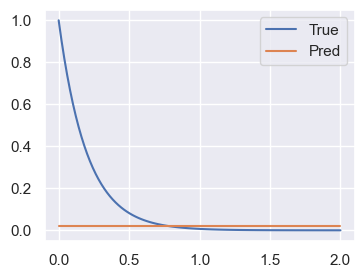

In [9]:
pred = net.predict(t_true.detach().numpy())

# Plot true and training data
plt.figure(figsize=(4,3))
plt.plot(t_true.detach().numpy(), y_true .cpu().numpy(), label='True')
plt.plot(t_true.detach().numpy(), pred, label='Pred')
plt.legend()
plt.show()

In [ ]:
net.k

In [ ]:
1/0

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import solve_ivp, odeint

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [ ]:
# Define the system of ODEs
def model(y, t, k1, k2):
    dy1dt = -k1 * y[0]
    dy2dt = k1 * y[0] - k2 * y[1]
    return [dy1dt, dy2dt]

y0 = [1, 0]
T_START = 0
T_END = 2
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k1 = 5
k2 = 1
solution = odeint(model, y0, t, args=(k1, k2))

# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)
z_2 = lambda t: 5/4 * np.exp(-5 * t) * (np.exp(4 * t) - 1)

# Create true data
t_true = torch.from_numpy(t).float().view(-1,1).to(DEVICE)
y_true = torch.from_numpy(solution).float().to(DEVICE)

# Make training data
n_samples = 24
t_train = torch.linspace(T_START, T_END, n_samples).view(-1,1).requires_grad_(True).to(DEVICE)
y_train = np.column_stack([z_1(t_train.cpu().detach().numpy()), z_2(t_train.cpu().detach().numpy())])
# Add small white noise to the training data
# y_train += 0.006 * torch.randn(n_samples, 2).to(DEVICE)


# Plot true and training data 
plt.plot(t_true.cpu().numpy(), y_true[:, 0] .cpu().numpy())
plt.plot(t_true.cpu().numpy(), y_true[:, 1] .cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_train[:, 0], 'o')
plt.plot(t_train.cpu().detach().numpy(), y_train[:, 1], 'o')
plt.show()

In [ ]:
def grad(outputs, inputs):
    """ Computes the partial derivative of 
    an output wrt an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [ ]:
def np_to_ts(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units=100) -> None:
        
        super().__init__()
        self.n_units = n_units
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
        
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out
        
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_ts(X))
        return out.detach().cpu().numpy()
    
class ParameterEstimation(Net):
    def __init__(self, input_dim, output_dim, n_units=100) -> None:
        super().__init__(input_dim, output_dim, n_units)
        
        self.k_1 = nn.Parameter(data=torch.tensor([1.]))
        self.k_2 = nn.Parameter(data=torch.tensor([1.]))

In [ ]:
net = ParameterEstimation(1,2, n_units=10).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

y_train = np_to_ts(y_train)

EPOCHS = 10000
for epoch in range(EPOCHS):
    # Forward pass
    y_pred = net(t_train)
    loss = criterion(y_pred, y_train) 
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, loss {round(loss.item(),4)}')

In [ ]:
# Plot true and pred on t_train
y_pred = net(t_train)
plt.plot(t_true.cpu().numpy(), y_true[:, 0].cpu().numpy())
plt.plot(t_true.cpu().numpy(), y_true[:, 1].cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_pred[:, 0].detach().cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_pred[:, 1].detach().cpu().numpy())
plt.show()

In [ ]:
from scipy.optimize import minimize

dy_pred = grad(y_pred[:,0], t_train)[0].cpu().detach().numpy()

y_train_np = y_train[:,0].cpu().detach().numpy()

def objective(k):
    return np.sum((dy_pred - (-k * y_train_np))**2)

result = minimize(objective, 1)
result.x

In [ ]:
from scipy.optimize import minimize_scalar

def objective(k_1):
    return torch.sum(grad(y_pred[:,0], t_train) - k_1 * y_pred[:,0])**2

result = minimize_scalar(objective)
optimal_k_1 = result.x

print("Optimal k_1:", optimal_k_1)
grad(y_pred[:,0], t_train) - k_1 * y_pred[:,0]